# Comparing Election Processes Using Optimal Candidate Strategy

### Abstract
Existing scholarship has focused on two methods for evaluating
election processes.  The first method is based on using ballots or
survey data of one form or another to infer voter preferences.  All
survey data is, by definition, influenced by the election process
under which that data was gathered.  The alternative is to assume a
normal distribution of voters over some dimensionality and a
corresponding selection of candidates drawn from that same
population.  This presumes that candidates make no attempt to adjust
their position to maximize their chance of winning.  Comparing the
outcomes by examining any set of ballots (real or hypothetical) under
multiple election processes presumes no alteration in candidate
behavior based on the election process.

We undertake to compare the outcomes under different voting systems when
candidates who chose their ideological positions to optimize their chance
of winning.

We use a neural network and techniques from reinforcement learning to
learn optimal strategy for candidates under each voting system at different
assumptions of the dimensionality of the ideological space.



### Introduction

_This goes into more detail that was referred to in the abstract and cites
the various papers that are relevant_

_It should also mention the snowball effect, individuals who have a chance to win under
a given system will be more likely to declare a candidacy, more likely to attract
media attention, donors, endorsements, etc.  This isn't all about assuming that candidates
will cynically adjust their policy_

### Voting Model

Voters use a preference model to choose their preferred candidate as follows:

$S = -||I_{C} - I_{V}|| + Q_{C} + U$

Where:

* $S$ is the score for the candidate
* $I$ is the $N$ dimensional ideology vector.  The dimensions are considered
to be orthogonal with unit variance.  Manhattan distance is used, but I intend to change that to Eluclidean
distance to reduce potential confusion.
* $Q$ is the quality of the candidate, it is held at zero for all simulations
* $U$ is the uncertainty is a unit gaussian * .375


The voter computes a score for each candidate, the ballot is constructed
in the order of the scores, highest first.

### Voting Systems

Two voting systems are considered:  Hare and Minimax.  These systems have been chosen
because existing results with random candidates and based on survey data suggest that these
methods agree most of the time.

_This needs to be expanded upon, list the papers showing this and the metrics used to
demonstrate that agreement._

The question is whether analysis using existing strategies of either survey data or
random candidates is predictive of actual outcomes.

### Results with Randomly Chosen Candidates

First we examine the outcomes when candidates are randomly drawn from the same
distribution as the voters.  This is perhaps the only situation where it is
reasonable to compare a set of ballots under two different voting systems.
Conversely, it only applies if there is preference to select viable candidates,
and the candidates do not alter their behavior to maximize their chance of
winning.  Perhaps, not the most reasonable of assumptions.

Nonetheless, this information is relevant for two reasons:  First, it provides some
reassurance that these results agree with existing scholarship that assumes random
candidates.  This validates both the voting model and the implementation of the
voting system.

Second, it is a useful reference to show how much the outcome is influenced when
candidates optimize their positions.  The voting reform effort is based on the idea
that election results will change if the voting system is changed.  It seems
appropriate to analyze the outcomes under the assumption that candidates will indeed
change under a different electoral system.

In [1]:
from typing import Set, Callable

from Ballot import Ballot
from CandidateModel import CandidateModel
from DefaultConfigOptions import *
from Election import Election
from ElectionResult import ElectionResult
from HeadToHeadElection import HeadToHeadElection
from InstantRunoffElection import InstantRunoffElection
from NDPopulation import NDPopulation

In [2]:
class ElectionConstructor:
    def __init__(self, constructor: Callable[[List[Ballot], Set[Candidate]], Election], name: str):
        self.constructor = constructor
        self.name = name

    def run(self, ballots: List[Ballot], candidates: Set[Candidate]) -> ElectionResult:
        e = self.constructor(ballots, candidates)
        return e.result()

def construct_irv(ballots: List[Ballot], candidates: Set[Candidate]):
    return InstantRunoffElection(ballots, candidates)

def construct_h2h(ballots: List[Ballot], candidates: Set[Candidate]):
    return HeadToHeadElection(ballots, candidates)

In [3]:
class Sample:
    def __init__(self, opponents: List[Candidate], candidate: Candidate):
        self.opponents = opponents.copy()
        self.candidate = candidate

In [4]:
def create_population(ideology_dim: int) -> (CandidateModel, NDPopulation):
    population_means = np.zeros(shape=(ideology_dim,))
    population_stddev = np.ones(shape=(ideology_dim,))
    pop = NDPopulation(population_means, population_stddev)
    return pop

In [5]:
class Stats:
    def __init__(self):
        self.winner_distance = 0
        self.results: List[Candidate] = []
    def reset(self):
        self.winner_distance = 0
        self.results = []
    def update(self, winner: Candidate):
        self.winner_distance += winner.ideology.distance_from_o()
        self.results += [winner]
    def print(self, label: str):
        print("%15s %5d " %
               (label,
               len(self.results)), end="")

        print("%5.2f" % (self.winner_distance / len(self.results)))

In [6]:
class ProcessResult:
    def __init__(self, process: ElectionConstructor, dim: int, stats: Stats):
        self.process = process
        self.dim = dim
        self.stats = stats

    def print(self):
        self.stats.print("%12s - %dD" % (self.process.name, self.dim))

In [7]:
def generate_candidates(population: NDPopulation, n_candidates: int) -> List[Candidate]:
    candidates = []
    for i in range(n_candidates):
        ideology = population.unit_sample_voter().ideology
        c = Candidate("r-" + str(i), Independents, ideology, 0)
        candidates += [c]
    return candidates

def run_process(processes: List[ElectionConstructor], dim: int, samples: int) -> List[ProcessResult]:
    results = {}
    for p in processes:
        results[p] = ProcessResult(p, dim, Stats())

    population = create_population(dim)
    for i in range(samples):
        voters = population.generate_unit_voters(100)
        candidates = generate_candidates(population, 6)
        ballots = [Ballot(v, candidates, unit_election_config) for v in voters]
        for process in processes:
            r = process.run(ballots, set(candidates))
            results[process].stats.update(r.winner())

    return list(results.values())

In [8]:
results = []
processes = [
    ElectionConstructor(constructor=construct_irv, name="Instant Runoff"),
    ElectionConstructor(constructor=construct_h2h, name="Head-to-Head")
]

for dim in [1,2,3,4]:
    results += run_process(processes, dim, 1000)

for r in results:
    r.print()

Instant Runoff - 1D  1000  0.68
Head-to-Head - 1D  1000  0.25
Instant Runoff - 2D  1000  0.94
Head-to-Head - 2D  1000  0.56
Instant Runoff - 3D  1000  1.23
Head-to-Head - 3D  1000  0.84
Instant Runoff - 4D  1000  1.54
Head-to-Head - 4D  1000  1.11


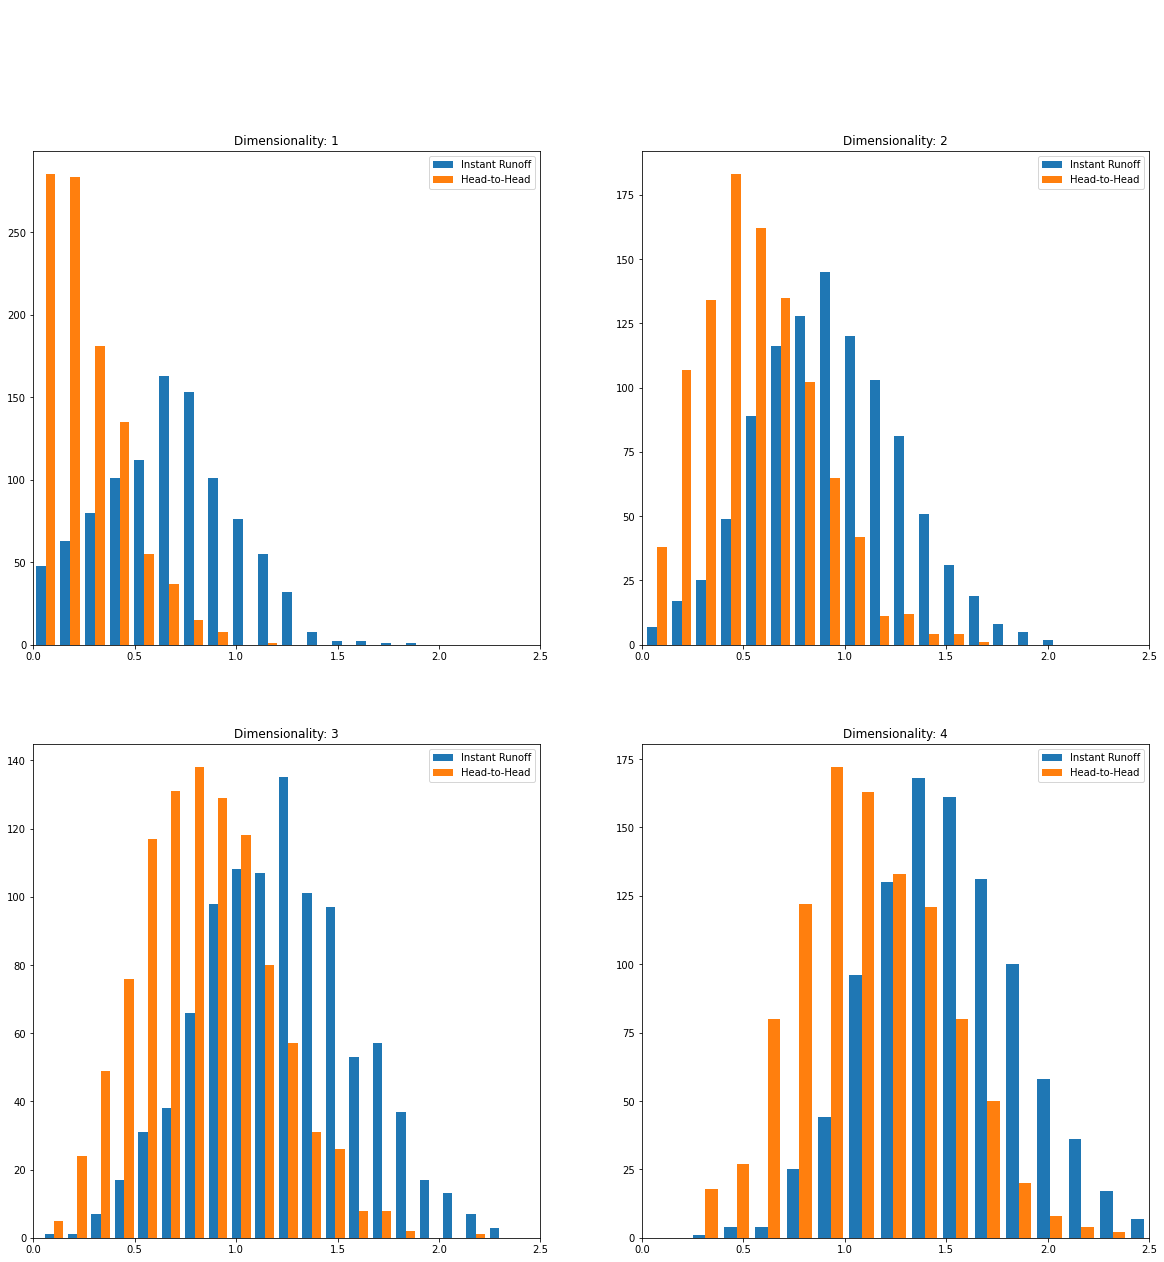

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
fig.suptitle("Random Candidates", color="white")

count = 0
irv_results = [r for r in results if r.process.name == "Instant Runoff"]
h2h_results = [r for r in results if r.process.name == "Head-to-Head"]

for ir, hr in zip(irv_results, h2h_results):
    assert(ir.dim == hr.dim)
    row = count // 2
    col = count % 2
    count += 1

    axis = axes[row][col]
    axis.tick_params(axis='x', colors="black")
    axis.tick_params(axis='y', colors="black")
    axis.set_xlim([0, 2.5])

    iv = [ w.ideology.distance_from_o() for w in ir.stats.results]
    hv = [ w.ideology.distance_from_o() for w in hr.stats.results]

    axis.hist([iv, hv], bins=30, label=[ir.process.name, hr.process.name])
    axis.set_title("Dimensionality: %d" % ir.dim, color="black")

    axis.legend()